In [2]:
# imports
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
from sql_config import protocol, username, password, host, port, database_name
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import csv
import os

---
# Load Clean Data from Postgres

In [3]:
# create db connection and engine
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)

# Read in the postgres cleaned data in table "app_data_clean" into a dataframe
df_clean = pd.read_sql_query('select * from proj4_sch.app_data_clean', con=engine)

In [4]:
# Check the dataframe
df_clean.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DOC_COUNT
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,2.0,0.0,-617.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [5]:
# Check the dataframe continued
df_clean.describe(include = 'all').round(3)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DOC_COUNT
count,307505.000,307505,307505,307505,307505,307505.000,3.075050e+05,307505.000,307505.000,307505.000,...,307505.000,307505.000,307505.000,307505.000,307505.000,307505.000,307505.000,307505.000,307505.000,307505.000
unique,NaN,2,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,278232,202447,202920,213306,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.081,NaN,NaN,NaN,NaN,0.416,1.687967e+05,599028.395,27107.580,537914.488,...,1.401,0.100,-962.859,0.006,0.006,0.030,0.231,0.230,1.643,0.930
std,0.272,NaN,NaN,NaN,NaN,0.715,2.371248e+05,402493.887,14494.547,369633.198,...,2.377,0.362,826.814,0.078,0.103,0.191,0.857,0.744,1.856,0.344
min,0.000,NaN,NaN,NaN,NaN,0.000,2.565000e+04,45000.000,0.000,0.000,...,0.000,0.000,-4292.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,NaN,NaN,NaN,NaN,0.000,1.125000e+05,270000.000,16524.000,238500.000,...,0.000,0.000,-1570.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
50%,0.000,NaN,NaN,NaN,NaN,0.000,1.471500e+05,513531.000,24903.000,450000.000,...,0.000,0.000,-757.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000
75%,0.000,NaN,NaN,NaN,NaN,1.000,2.025000e+05,808650.000,34596.000,679500.000,...,2.000,0.000,-274.000,0.000,0.000,0.000,0.000,0.000,3.000,1.000


In [6]:
print(df_clean.dtypes)

TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
                               ...   
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
DOC_COUNT                       int64
Length: 71, dtype: object


In [7]:
# Check the dataframe continued
print (df_clean.shape)
print (df_clean.columns)

(307505, 71)
Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEA

In [8]:
# Set the color palette
color_taupe = (150/255, 140/255, 140/255)       # Taupe
color_sage = (165/255, 171/255, 129/255)        # Sage
color_rust = (221/255, 128/255, 71/255)         # Rust
color_green = (123/255, 167/255, 157/255)       # Green
color_blue = (148/255, 182/255, 210/255)        # ice Blue
color_brown = (119/255, 95/255, 85/255)         # Brown
color_gold = (216/255, 178/255, 92/255)         # Brown
color_tan = (235/255, 221/255, 195/255)         # Brown
color_clay = (188/255, 143/255, 143/255)        # Clay

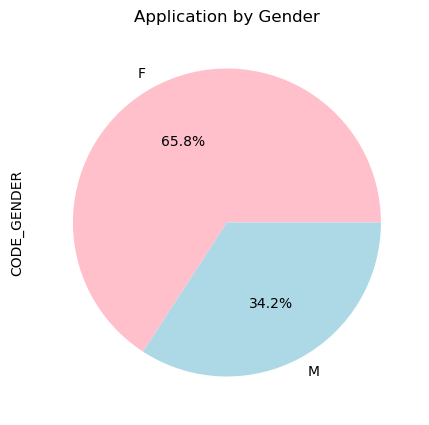

In [35]:
# for color choices see matplotlib named_colors.jpynb
plt.title("Application by Gender")
#plt.ylabel("Count")
#plt.xlabel("Gendar")
df_clean['CODE_GENDER'].value_counts().plot(kind='pie'
            , colors=['pink', 'lightblue']
            , autopct="%1.1f%%"
            , figsize=(10,5))

save_fig = os.path.join('.','Images', 'Gender.jpg')             # Prepare to save the figure  
plt.savefig(save_fig, bbox_inches='tight')                                  # Save the figure

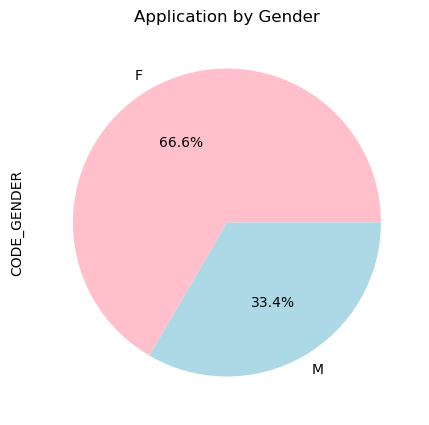

In [50]:
df_clean_no_risk = df_clean[df_clean['TARGET']==0]
# for color choices see matplotlib named_colors.jpynb
plt.title("Application by Gender (no risk)")
#plt.ylabel("Count")
#plt.xlabel("Gendar")
df_clean_no_risk['CODE_GENDER'].value_counts().plot(kind='pie'
            , colors=['pink', 'lightblue']
            , autopct="%1.1f%%"
            , figsize=(10,5))

save_fig = os.path.join('.','Images', 'Gender_no_risk.jpg')             # Prepare to save the figure  
plt.savefig(save_fig, bbox_inches='tight')                                  # Save the figure

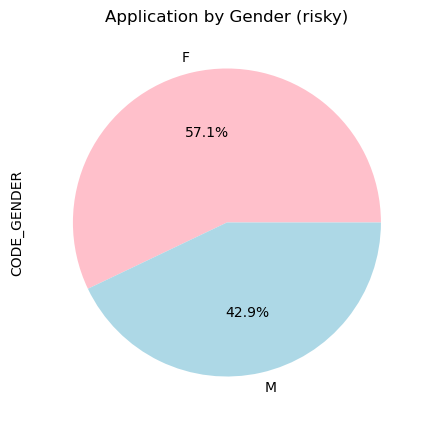

In [51]:
df_clean_risk = df_clean[df_clean['TARGET']==1]
# for color choices see matplotlib named_colors.jpynb
plt.title("Application by Gender (risky)")
#plt.ylabel("Count")
#plt.xlabel("Gendar")
df_clean_risk['CODE_GENDER'].value_counts().plot(kind='pie'
            , colors=['pink', 'lightblue']
            , autopct="%1.1f%%"
            , figsize=(10,5))

save_fig = os.path.join('.','Images', 'Gender_risk.jpg')             # Prepare to save the figure  
plt.savefig(save_fig, bbox_inches='tight')    

In [48]:
df_clean_no_risk.head()


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DOC_COUNT
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,2.0,0.0,-617.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0.0,0.0,-2536.0,0.0,0.0,0.0,0.0,1.0,1.0,1


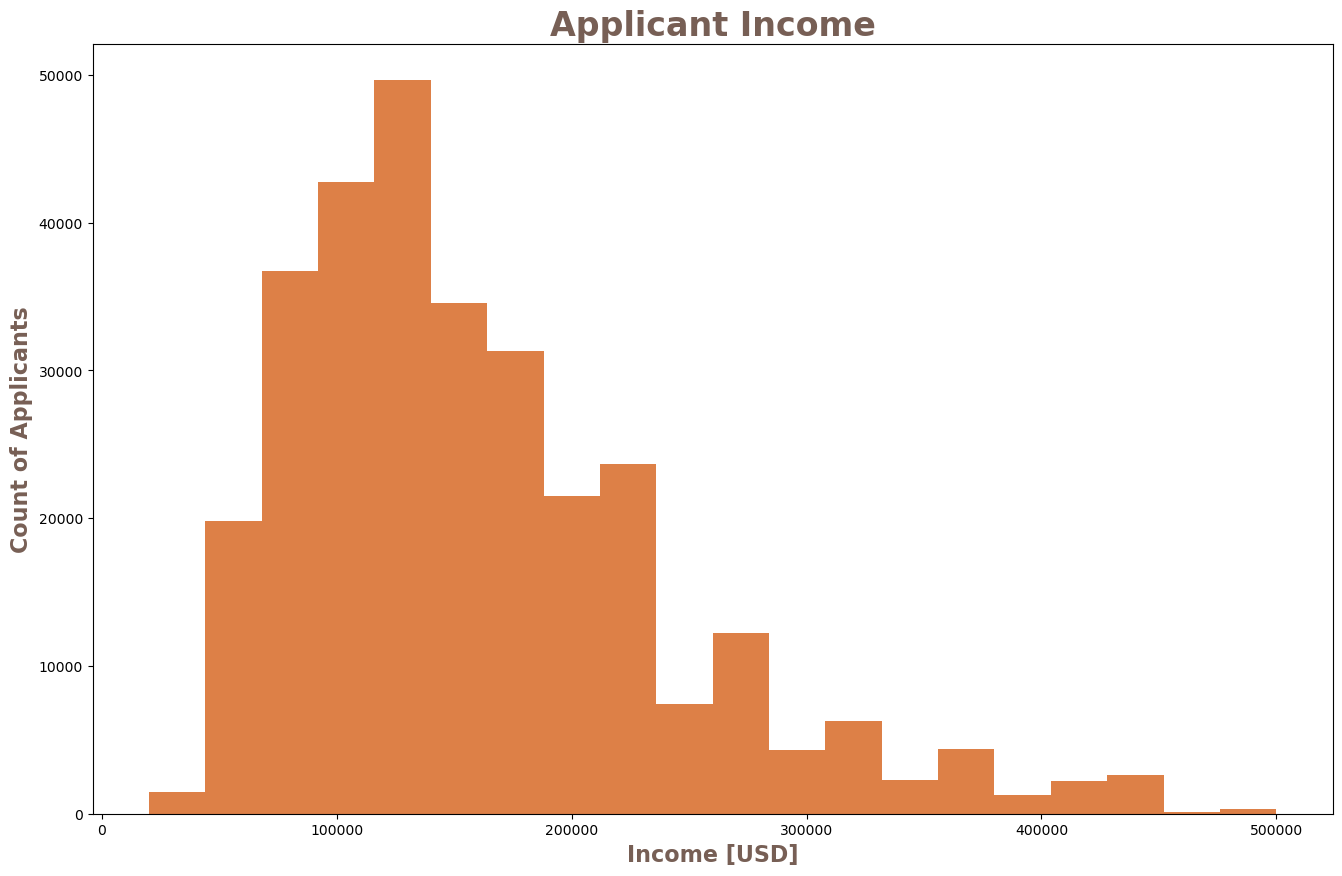

In [10]:
#df.plot(kind='Histogram')
plt.figure(figsize=(16,10)) 

plt.hist(df_clean['AMT_INCOME_TOTAL'], color=color_rust, bins=20,range=(20000,500000)); 
plt.title('Applicant Income',                    # Add a title
            fontsize = 24,
            color=color_brown, 
            fontweight="bold")         
plt.ylabel("Count of Applicants",                                               # Add a y-axis description
            fontsize = 16, 
            color=color_brown, 
            fontweight="bold")                              
plt.xlabel("Income [USD]",                                                 # Add a x-axis descrition
            fontsize = 16,
            color=color_brown, 
            fontweight="bold")

save_fig = os.path.join('.','Images', 'Income_Histogram.jpg')             # Prepare to save the figure  
plt.savefig(save_fig, bbox_inches='tight')                                  # Save the figure

In [15]:
df_clean['DAYS_BIRTH'].describe

<bound method NDFrame.describe of 0         -9461
1        -16765
2        -19046
3        -19005
4        -19932
          ...  
307500    -9327
307501   -20775
307502   -14966
307503   -11961
307504   -16856
Name: DAYS_BIRTH, Length: 307505, dtype: int64>

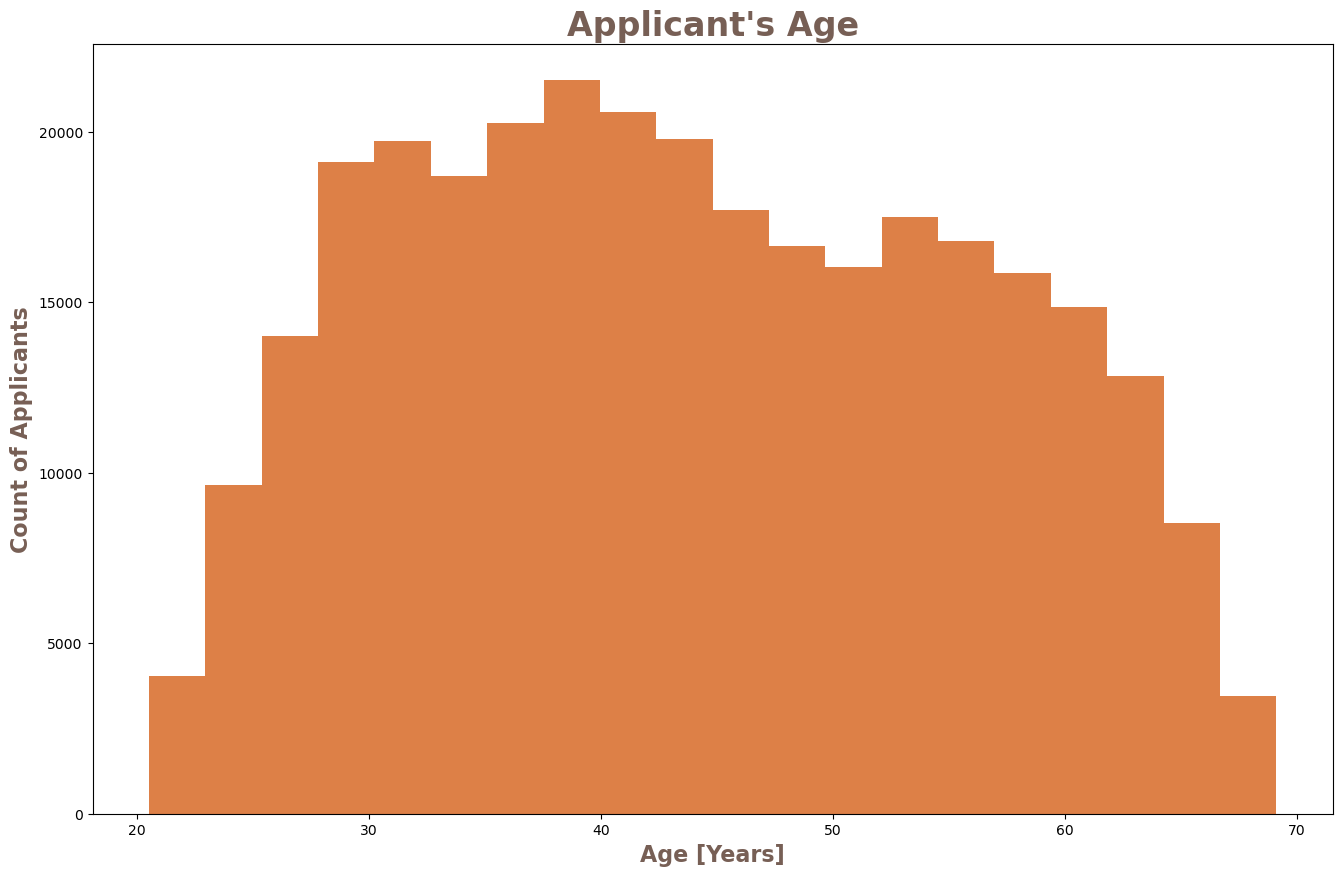

In [22]:
#df.plot(kind='Histogram')
plt.figure(figsize=(16,10)) 

plt.hist(-df_clean['DAYS_BIRTH']/365, color=color_rust, bins=20,); 
plt.title("Applicant's Age",                    # Add a title
            fontsize = 24,
            color=color_brown, 
            fontweight="bold")         
plt.ylabel("Count of Applicants",                                               # Add a y-axis description
            fontsize = 16, 
            color=color_brown, 
            fontweight="bold")                              
plt.xlabel("Age [Years]",                                                 # Add a x-axis descrition
            fontsize = 16,
            color=color_brown, 
            fontweight="bold")

save_fig = os.path.join('.','Images', 'Age of Applicant.jpg')             # Prepare to save the figure  
plt.savefig(save_fig, bbox_inches='tight')                                  # Save the figure

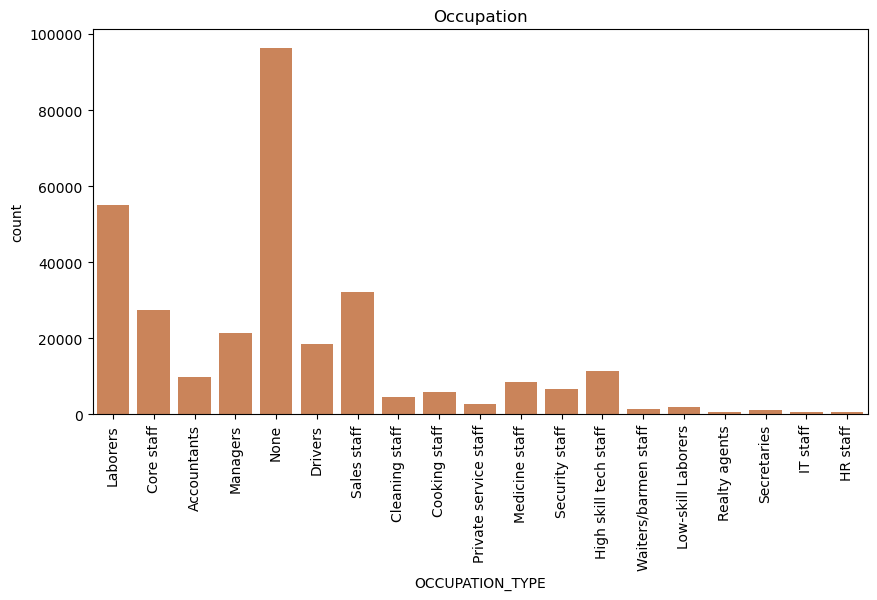

In [43]:
df_clean['OCCUPATION_TYPE'] = df_clean['OCCUPATION_TYPE'].replace ('0','None')
plt.figure(figsize=(10,5))
plt.title("Occupation")
chart = sns.countplot(x='OCCUPATION_TYPE', data=df_clean, color=color_rust)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

save_fig = os.path.join('.','Images', 'Occupation.jpg')             # Prepare to save the figure  
plt.savefig(save_fig, bbox_inches='tight')                                  # Save the figure